In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
# Referred to Midterm template, Sree's practice notebook and GPT
class BRATS2020Dataset(Dataset):
    """
    Dataset class for BRATS2020 .h5 files. 
    Assumes each .h5 file contains 'image' and 'mask' keys.
    """

    def __init__(self, root_dir, n_sample=None, image_size=(256, 256), mask_size=(256, 256)):
        """
        Args:
            root_dir (str): Root directory with .h5 files.
            n_sample (int, optional): Number of samples to use. Defaults to all.
            image_size (tuple): Target image size.
            mask_size (tuple): Target mask size.
        """
        self.root_dir = root_dir
        self.file_paths = sorted(glob.glob(os.path.join(root_dir, '*.h5')))

        if n_sample and n_sample < len(self.file_paths):
            self.file_paths = self.file_paths[:n_sample]

        self.n_sample = len(self.file_paths)
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize(image_size),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.msk_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(mask_size, interpolation=transforms.InterpolationMode.NEAREST)
        ])

    def __len__(self):
        return self.n_sample

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Assume shape (H, W)
            mask = np.array(f['mask'])    # Assume shape (H, W, C) or (H, W)

            # Optional channel weighting (0.1 for background class) #GPT referred here
            if mask.ndim == 3:
                mask = np.concatenate([np.ones((*mask.shape[:2], 1)) * 0.1, mask], axis=-1)
                mask = np.argmax(mask, axis=-1)

        image = self.img_transform(image)
        mask = self.msk_transform(mask).squeeze(0).long()

        return {
            'image': image,
            'mask': mask,
            'filename': os.path.basename(file_path)
        }
        

torch.Size([4, 256, 256]) torch.Size([256, 256]) volume_100_slice_107.h5
Image shape: (240, 240, 4), Mask shape: (240, 240, 3)


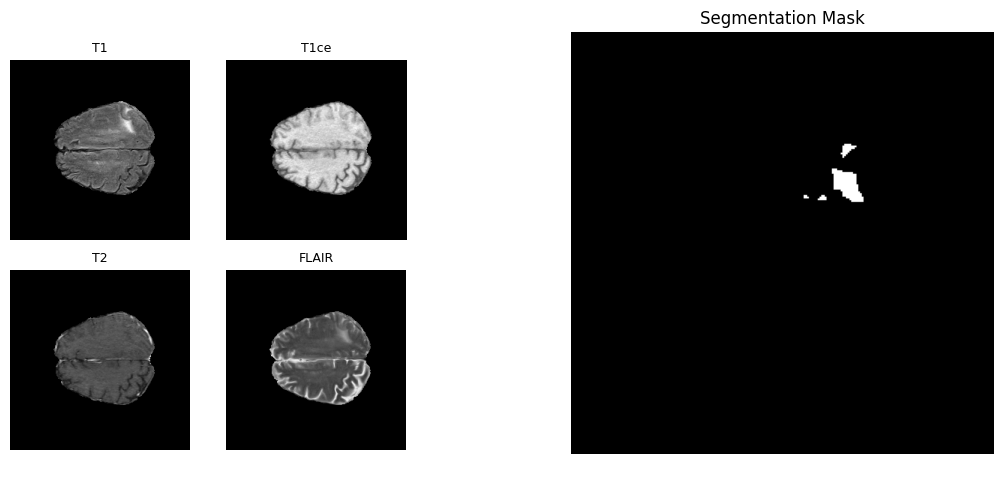

In [ ]:
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
dataset = BRATS2020Dataset(data_dir, n_sample=10000)
sample = dataset[10]
print(sample['image'].shape, sample['mask'].shape, sample['filename'])

file_path = os.path.join(data_dir, sample['filename'])
with h5py.File(file_path, 'r') as f:
    image = np.array(f['image'])         # Shape: (H, W)
    mask = np.array(f['mask'])           # Shape: (H, W) or (H, W, C)

    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

    # If mask has multiple channels (e.g., 3-class one-hot), take argmax (GPT referred here)
    if mask.ndim == 3:
        mask_display = np.argmax(mask, axis=-1)
    else:
        mask_display = mask


# GPT referred for plotting
# Modality labels
modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']

# Create figure with 2 main panels
fig = plt.figure(figsize=(12, 6))

# Subplot 1: 2x2 grid for the 4 modalities
grid_ax = plt.subplot(1, 2, 1)
grid_ax.axis('off')  # Hide the outer subplot (acts as container)

# 2x2 grid of subplots within subplot 1
for i in range(4):
    row = i // 2
    col = i % 2
    ax = fig.add_axes([0.08 + col*0.18, 0.15 + (1 - row)*0.35, 0.15, 0.3])  # [left, bottom, width, height]
    ax.imshow(image[:, :, i], cmap='gray')
    ax.set_title(modality_names[i], fontsize=9)
    ax.axis('off')

# Subplot 2: Segmentation mask
ax_mask = plt.subplot(1, 2, 2)
ax_mask.imshow(mask_display, cmap='gray')
ax_mask.set_title('Segmentation Mask')
ax_mask.axis('off')
plt.show()

In [4]:
train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1- train_ratio - test_ratio
train_size = int(train_ratio * len(dataset)) 
val_size = int(test_ratio * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size= 16
train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= batch_size, shuffle = False)
test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [ ]:
import torch
import torch.nn as nn

######################################## Double Convolution with residual connection
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.use_residual = in_channels == out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)

        if not self.use_residual:
            self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        out = self.double_conv(x)
        if self.use_residual:
            out += residual
        else:
            out += self.res_conv(residual)
        return self.relu(out)

######################################## Down Block (Maxpool + DoubleConv)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

######################################## Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

######################################## Up Block with Attention
class UpAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )
        self.attention = AttentionBlock(F_g=out_channels, F_l=out_channels, F_int=out_channels // 2)
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x2 = self.attention(g=x1, x=x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output Convolution
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

######################################## Full Attention U-Net
class UNet_Attention(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet_Attention, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Halved the number of channels to reduce memory usage
        self.inputL = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.up1 = UpAttention(512, 256)
        self.up2 = UpAttention(256, 128)
        self.up3 = UpAttention(128, 64)
        self.up4 = UpAttention(64, 32)

        self.outputL = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inputL(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.outputL(x)

######################################## Instantiate the model
my_UNet = UNet_Attention(name='AttentionUNet', n_channels=4, n_classes=4).cuda()


Image shape: torch.Size([16, 4, 256, 256])
Mask shape: torch.Size([16, 256, 256])
Prediction shape: torch.Size([16, 4, 256, 256])


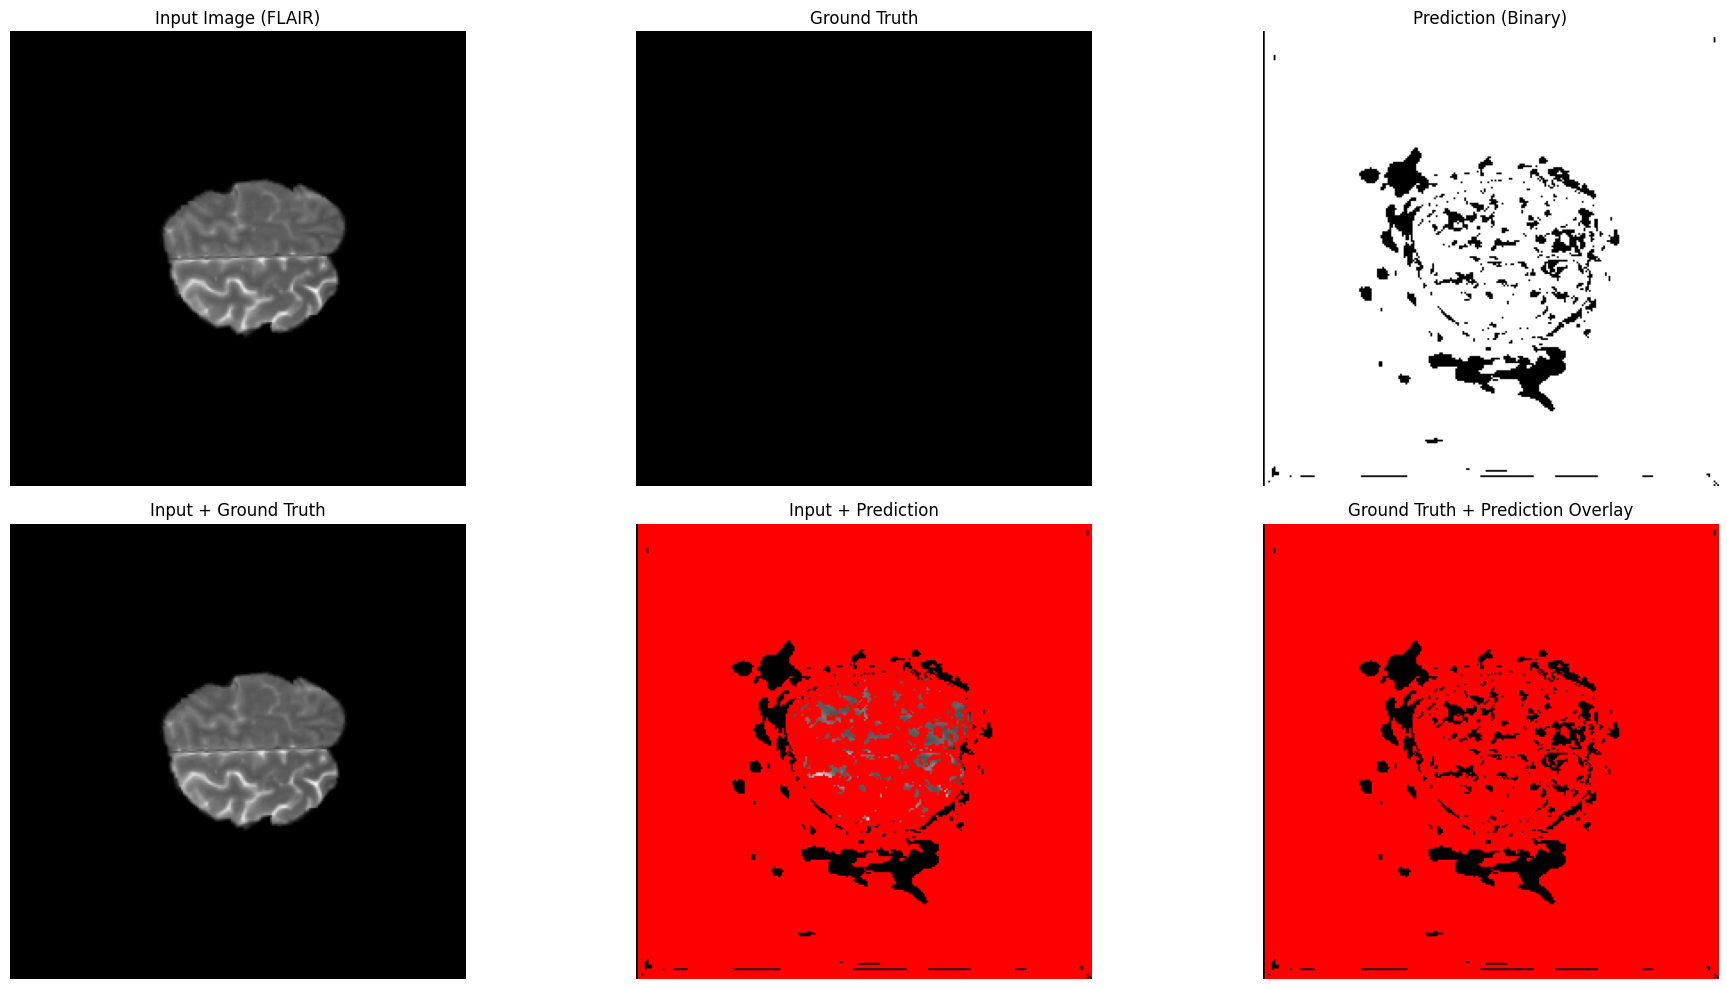

In [ ]:

for batch in test_loader:
    sample_batch = batch
    break  # just one sample

# Inference
with torch.no_grad():
    input_img = sample_batch['image'].cuda()  # shape: [1, 4, H, W]
    y_pred = my_UNet(input_img)

# Print shapes
print('Image shape:', sample_batch['image'].shape)
print('Mask shape:', sample_batch['mask'].shape)
print('Prediction shape:', y_pred.shape)

# Get grayscale image for visualization — e.g., FLAIR (channel 3) of sample 0
img = sample_batch['image'][0, 3].cpu().numpy()  # shape: (256, 256)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
img = (img * 255).astype('uint8')  # Convert to uint8 for display

# Ground truth mask for sample 0
msk = sample_batch['mask'][0].cpu().numpy()  # shape: (256, 256)
msk_bin = (msk > 0).astype('uint8') * 255  # Binary version for overlaying

# Prediction for sample 0
pred_softmax = torch.softmax(y_pred, dim=1)  # shape: [16, 4, 256, 256]
pred_class = torch.argmax(pred_softmax, dim=1)[0].cpu().numpy()  # shape: (256, 256)
pred_bin = (pred_class > 0).astype('uint8') * 255  # Binary for overlay

plt.figure(figsize=(20, 10))

plt.subplot(2,3,1)
plt.title('Input Image (FLAIR)')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth')
plt.imshow(msk_bin, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Prediction (Binary)')
plt.imshow(pred_bin, cmap='gray')
plt.axis('off')

# Overlay GT on input
img_overlay_gt = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_gt[msk_bin == 255] = [0, 255, 0]

plt.subplot(2,3,4)
plt.title('Input + Ground Truth')
plt.imshow(img_overlay_gt)
plt.axis('off')

# Overlay Pred on input
img_overlay_pred = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_pred[pred_bin == 255] = [255, 0, 0]

plt.subplot(2,3,5)
plt.title('Input + Prediction')
plt.imshow(img_overlay_pred)
plt.axis('off')

# Overlay both
combined = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_GRAY2RGB)
combined[msk_bin == 255, 1] = 255  # green
combined[pred_bin == 255, 0] = 255  # red

plt.subplot(2,3,6)
plt.title('Ground Truth + Prediction Overlay')
plt.imshow(combined)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model= my_UNet.to(device)
loss_function= torch.nn.CrossEntropyLoss() 
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001) 

In [ ]:
# Reference: Midterm Notebook, Attention baseline

def dice_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    dices = []
    for cls in range(1, num_classes): 
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum
        dice = (2 * inter + eps) / (union + eps)
        dices.append(dice.item())
    return np.mean(dices) if len(dices) > 0 else 0.0
    
def jaccard_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    jaccards = []
    for cls in range(1, num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum - inter
        jaccard = (inter + eps) / (union + eps)
        jaccards.append(jaccard.item())
    return np.mean(jaccards) if len(jaccards) > 0 else 0.0
    

def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            y_pred = net(imgs)
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)
            pred_class = torch.argmax(y_pred, dim=1)
            batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
            train_batch_dice.append(batch_dice_score)
            batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.mean(train_batch_dice) if train_batch_dice else 0.0
        average_training_jaccard = np.array(train_batch_jaccard).mean() if train_batch_jaccard else 0.0
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()
                y_pred = net(imgs)
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)
                pred_class = torch.argmax(y_pred, dim=1)
                batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
                valid_batch_dice.append(batch_dice_score)
                                
                # Compute the Jaccard score here and append the score to the list
                batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean() if valid_batch_dice else 0.0
        average_validation_jaccard = np.array(valid_batch_jaccard).mean() if valid_batch_jaccard else 0.0
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard

In [10]:
EPOCHS = 30
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_loader, val_loader, optimizer, loss_function)

EPOCH 1/30 - Training Loss: 0.04533962962259092, Training DICE score: 0.4531870884250595, Training Jaccard score: 0.35459082255907803, Validation Loss: 0.011881703799146982, Validation DICE score: 0.6356244411153706, Validation Jaccard score: 0.5057021253290688
EPOCH 2/30 - Training Loss: 0.011629213129550849, Training DICE score: 0.6395160685251738, Training Jaccard score: 0.5119204835764853, Validation Loss: 0.012444757139458069, Validation DICE score: 0.6530733140057357, Validation Jaccard score: 0.5136219281407576
EPOCH 3/30 - Training Loss: 0.009870246778344353, Training DICE score: 0.6966791339294279, Training Jaccard score: 0.567127365961581, Validation Loss: 0.009170076107635858, Validation DICE score: 0.7360667077597801, Validation Jaccard score: 0.605444470755559
EPOCH 4/30 - Training Loss: 0.00867499132905385, Training DICE score: 0.7378256198521795, Training Jaccard score: 0.6111530968126774, Validation Loss: 0.008262506567887844, Validation DICE score: 0.7384268830494138, 

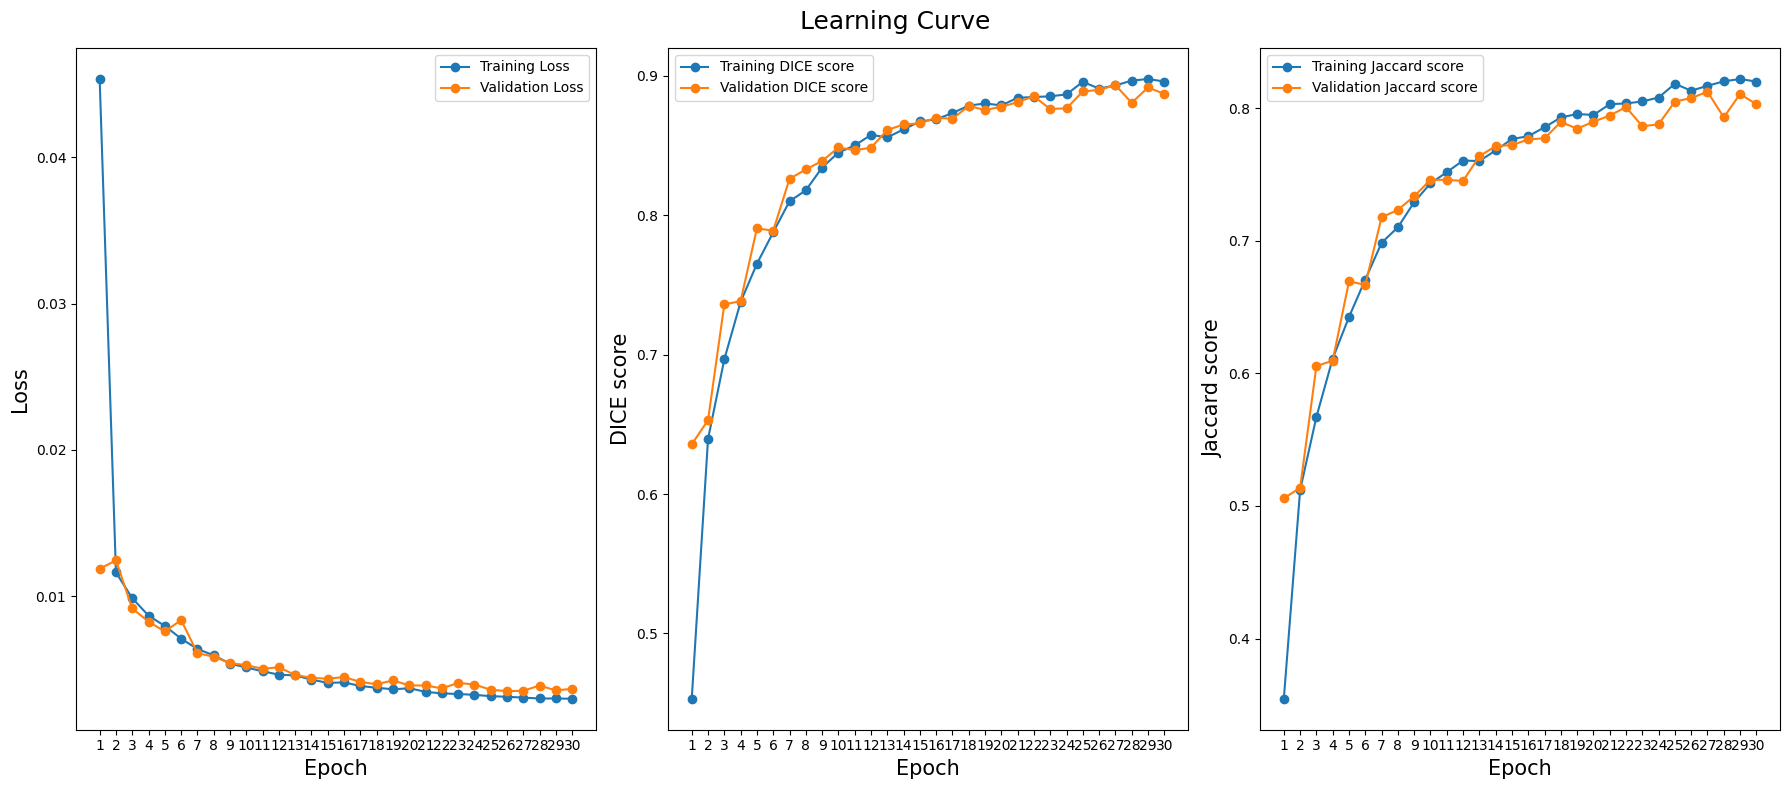

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
import os
import numpy as np
import torch

best_epoch = np.argmax(valid_dice) + 1
print(f'Best epoch is epoch {best_epoch}')

model_dir = "AttentionUNet"
best_model_path = os.path.join(model_dir, f'epoch_{best_epoch:03}.pth')

if os.path.exists(best_model_path):
    state_dict = torch.load(best_model_path)
    torch.save(state_dict, os.path.join(model_dir, 'best_model.pth'))
    print("✅ Best model saved as best_model.pth")
else:
    print(f"❌ Checkpoint file {best_model_path} not found")


Best epoch is epoch 27
✅ Best model saved as best_model.pth


/tmp/ipykernel_31/4210693682.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path)


In [18]:
print(f"Model name (save folder): {model.name}")


Model name (save folder): AttentionUNet


Sample batch "image" shape: torch.Size([16, 4, 256, 256])
Sample batch "mask" shape: torch.Size([16, 256, 256])
Predicted mask shape: torch.Size([16, 4, 256, 256])


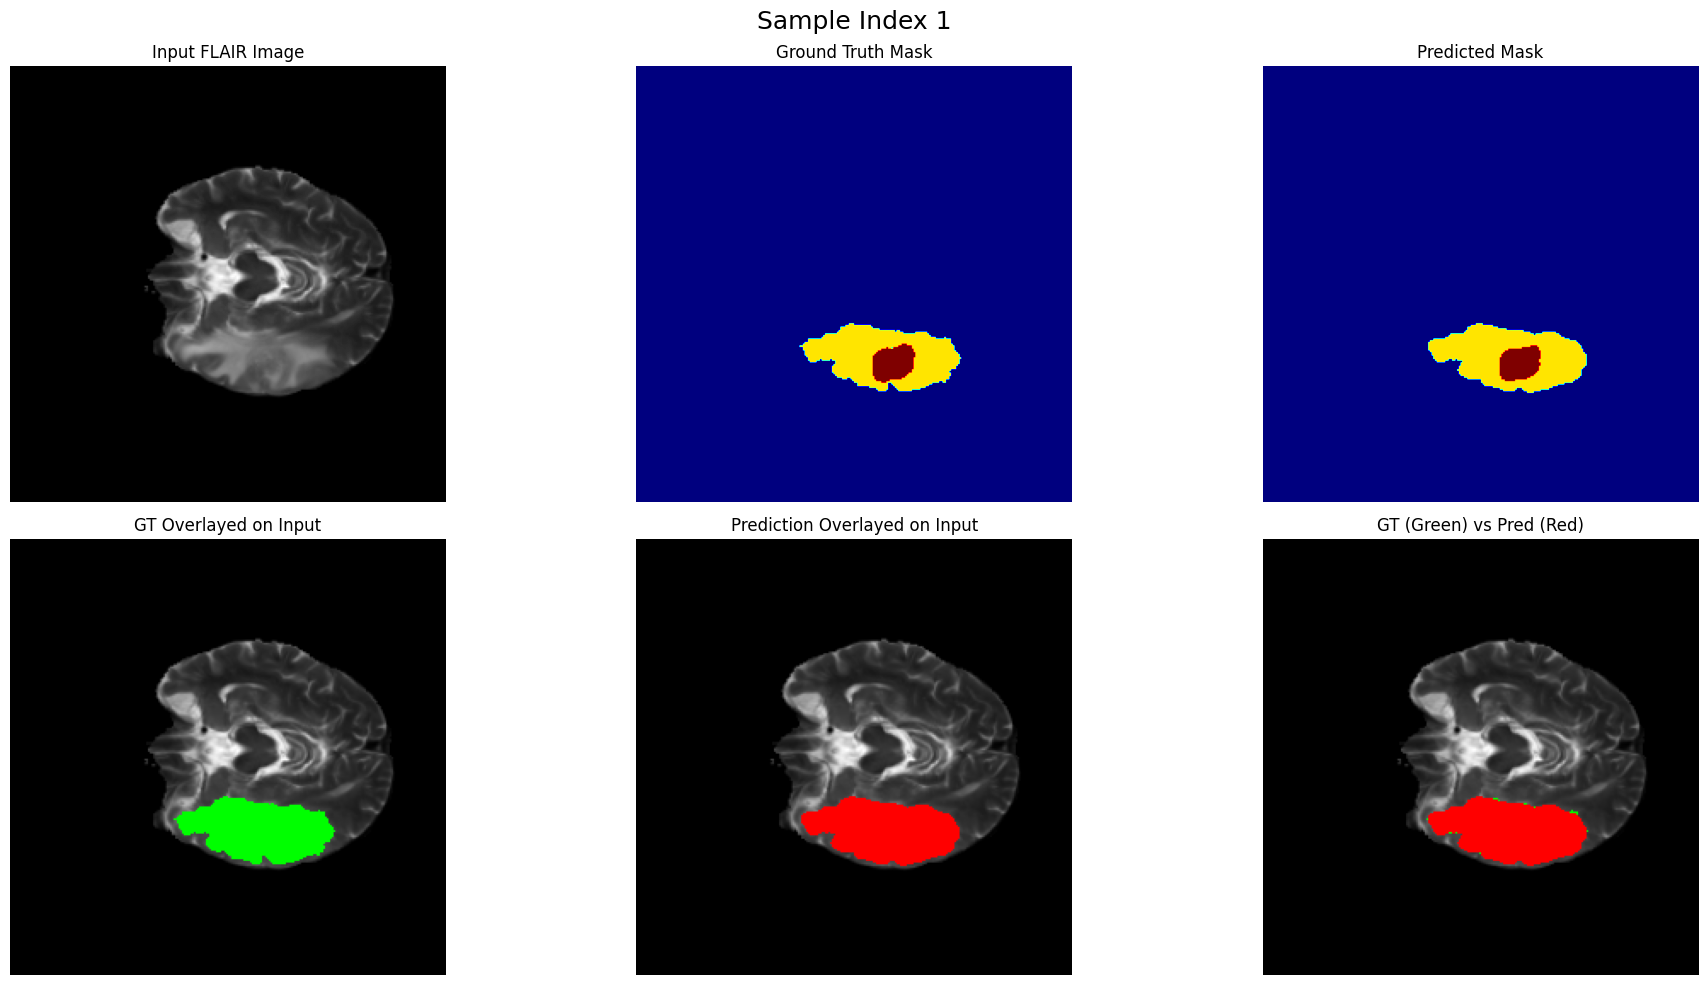

In [ ]:
for batch in test_loader:
    sample_batch = batch
    break

# Generate network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Predicted mask shape:', y_pred.shape)

i = 1  
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  
img = (img * 255).astype('uint8')  

msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255 

img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Testing Loop: Baseline reference- Midterm notebook
def test_net(net, test_dataloader, loss_function, save_dir='/kaggle/working/pred_mask', class_labels=[0, 1, 2, 4]):
    import os
    from sklearn.metrics import confusion_matrix, accuracy_score

    os.makedirs(save_dir, exist_ok=True)
    
    net.eval()
    
    test_batch_loss = []
    test_batch_dice = []
    test_batch_jaccard = []
    test_batch_accuracy = []
    test_batch_CM = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            imgs = batch['image'].cuda()             # [B, 4, H, W]
            true_masks = batch['mask'].cuda()        # [B, H, W]
            filenames = batch.get('filename', [f'{i}_{j}.png' for j in range(imgs.shape[0])])  # fallback

            y_pred = net(imgs)                       # [B, C, H, W]
            loss = loss_function(y_pred, true_masks)
            test_batch_loss.append(loss.item())
            pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # [B, H, W]

            dice = dice_coeff_multiclass(pred_class, true_masks)
            jaccard = jaccard_coeff_multiclass(pred_class, true_masks)
            test_batch_dice.append(dice)
            test_batch_jaccard.append(jaccard)
            flat_true = true_masks.view(-1).cpu().numpy()
            flat_pred = pred_class.view(-1).cpu().numpy()
            acc = accuracy_score(flat_true, flat_pred)
            cm = confusion_matrix(flat_true, flat_pred, labels=class_labels, normalize='true')

            test_batch_accuracy.append(acc)
            test_batch_CM.append(cm)

            for k in range(pred_class.shape[0]):
                filename = os.path.splitext(os.path.basename(filenames[k]))[0]
                pred_np = pred_class[k].cpu().numpy().astype('uint8')
                save_path = os.path.join(save_dir, f'{filename}_pred.png')
                cv2.imwrite(save_path, pred_np)

            print(f'[TEST] Batch {i+1}/{len(test_dataloader)} - Loss: {loss.item():.4f}, Dice: {dice:.4f}, Jaccard: {jaccard:.4f}, Acc: {acc:.4f}', end='\r')
    test_loss = np.mean(test_batch_loss)
    test_dice = np.mean(test_batch_dice)
    test_jaccard = np.mean(test_batch_jaccard)
    test_accuracy = np.mean(test_batch_accuracy)
    test_CM = np.mean(test_batch_CM, axis=0)

    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM

Test Loss: 0.003616670161951333, Test DICE score: 0.8848474879264832, Test Jaccard score: 0.8023780961036682, Test overall accuracy: 0.9985497207641602
------------------------------------------------------------------------------------------------------------------------------------


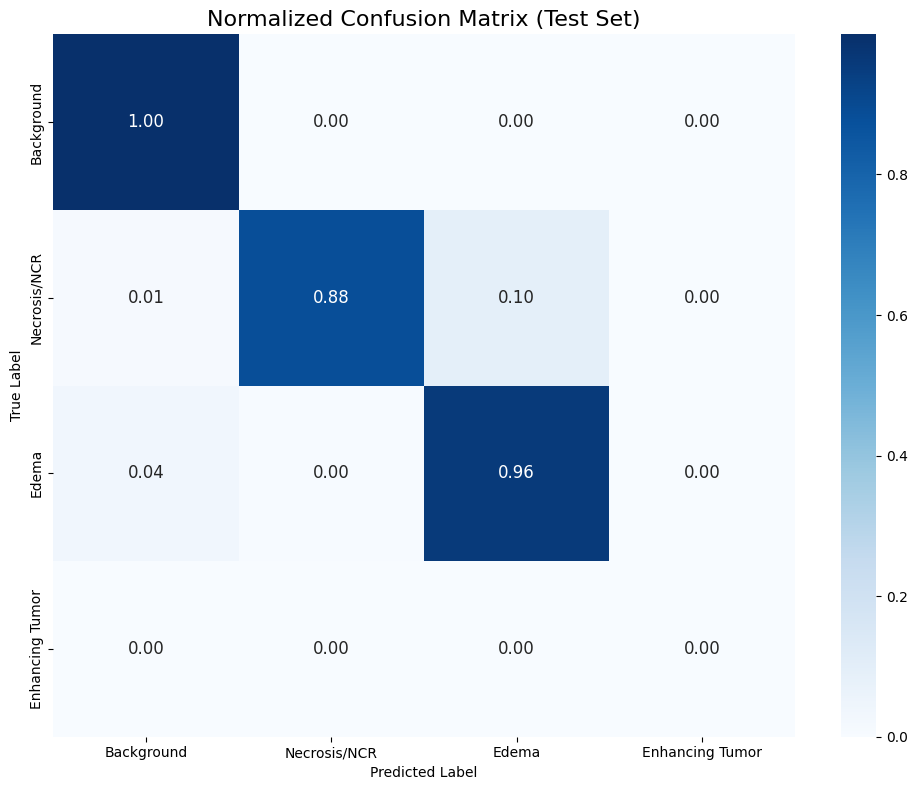

In [ ]:
# Reference: Midterm Notebook
import pandas as pd
import seaborn as sns
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_loader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')
print('------------------------------------------------------------------------------------------------------------------------------------')

class_labels = [0, 1, 2, 4]
class_names = ['Background', 'Necrosis/NCR', 'Edema', 'Enhancing Tumor']

# Create confusion matrix DataFrame
df_cm = pd.DataFrame(test_CM, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 12})
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [30]:
from IPython.display import FileLink
FileLink('')  # Replace with your file name


/kaggle/working/AttentionUNet/best_model.pth

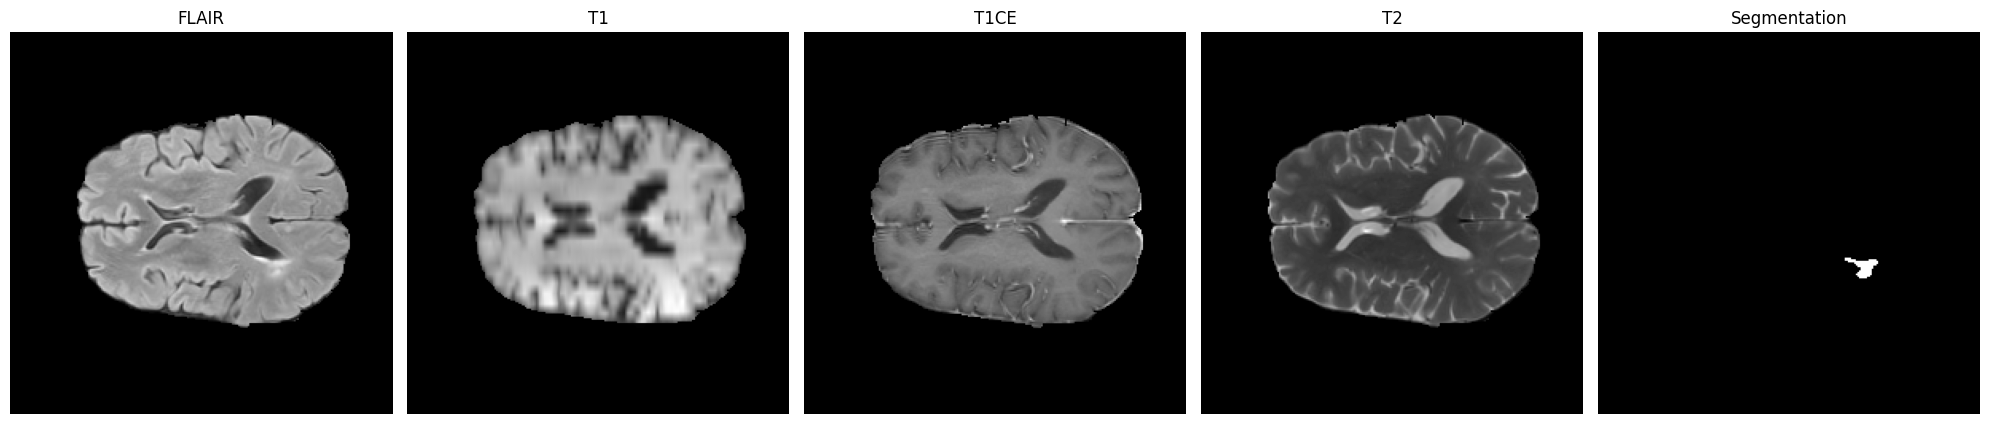

In [7]:
# Base path to dataset
base_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Pick a random sample
subject = random.choice(os.listdir(base_path))
subject_path = os.path.join(base_path, subject)

# File paths
flair_path = os.path.join(subject_path, f"{subject}_flair.nii")
t1_path    = os.path.join(subject_path, f"{subject}_t1.nii")
t1ce_path  = os.path.join(subject_path, f"{subject}_t1ce.nii")
t2_path    = os.path.join(subject_path, f"{subject}_t2.nii")
seg_path   = os.path.join(subject_path, f"{subject}_seg.nii")

# Load volumes
flair = nib.load(flair_path).get_fdata()
t1    = nib.load(t1_path).get_fdata()
t1ce  = nib.load(t1ce_path).get_fdata()
t2    = nib.load(t2_path).get_fdata()
seg   = nib.load(seg_path).get_fdata()

# Pick a slice index from middle
slice_idx = flair.shape[2] // 2

# Plot
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(flair[:, :, slice_idx], cmap='gray'); axs[0].set_title('FLAIR')
axs[1].imshow(t1[:, :, slice_idx], cmap='gray'); axs[1].set_title('T1')
axs[2].imshow(t1ce[:, :, slice_idx], cmap='gray'); axs[2].set_title('T1CE')
axs[3].imshow(t2[:, :, slice_idx], cmap='gray'); axs[3].set_title('T2')
axs[4].imshow(seg[:, :, slice_idx],cmap='gray'); axs[4].set_title('Segmentation')
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channel = 4
output_channel = 4

# Step 1: Create the model
best_model = UNet_Attention('AttentionUNet', input_channel, output_channel)
best_model.to(device)

# Step 2: Load weights into it
state_dict = torch.load("/kaggle/input/bestmodel/attentionUNet.pth", map_location=device)
best_model.load_state_dict(state_dict)

# Step 3: Set to eval mode
best_model.eval()

/tmp/ipykernel_31/1796692708.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/bestmodel/attentionUNet.pth", map_location=device)


UNet_Attention(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
    (res_conv): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), strid

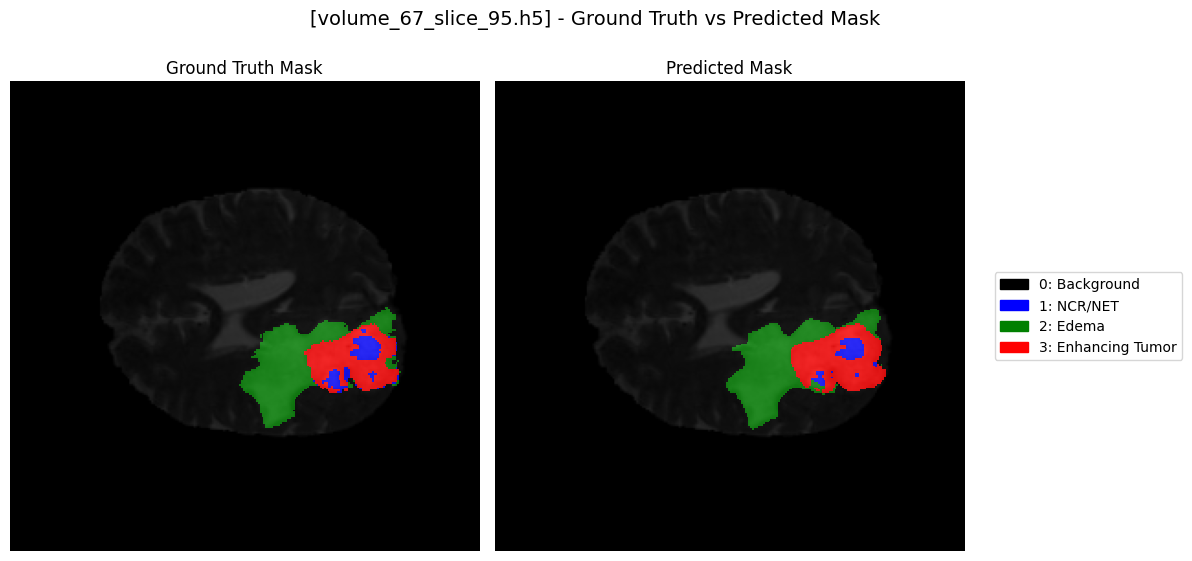

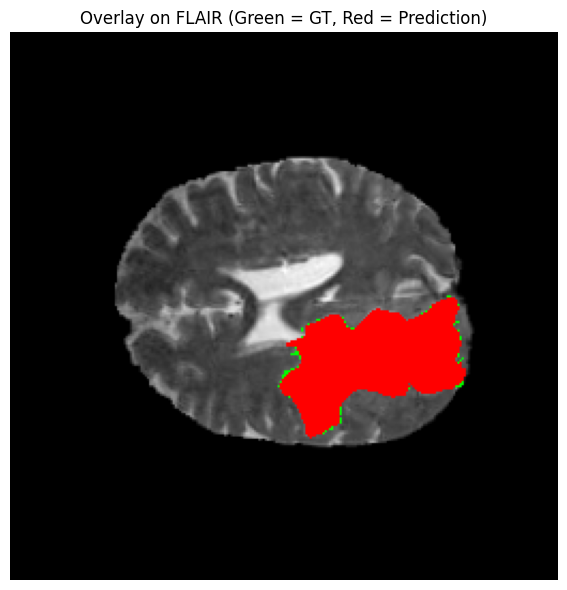

In [8]:

#Testing one particular image:
import torch
import torchvision.transforms as transforms
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os

# Load the file
file_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_67_slice_95.h5"
with h5py.File(file_path, 'r') as f:
    img_data = np.array(f['image'])        # (240, 240, 4)
    mask_data = np.array(f['mask'])        # (240, 240) or (240, 240, 3)

# --- Apply Dataset-style preprocessing ---

# Image transform
img_transform = transforms.Compose([
    transforms.ToTensor(),  # → (C, H, W), scaled [0, 1]
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5], std=[0.5])  # → [-1, 1]
])

# Mask transform
msk_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

# Handle mask shape
if mask_data.ndim == 3:
    mask_data = np.concatenate([np.ones((*mask_data.shape[:2], 1)) * 0.1, mask_data], axis=-1)
    mask_data = np.argmax(mask_data, axis=-1)

# Apply transforms
img_tensor = img_transform(img_data)         # shape: (4, 256, 256)
mask_tensor = msk_transform(mask_data).squeeze(0).long()  # shape: (256, 256)

# Inference
input_tensor = img_tensor.unsqueeze(0).cuda()  # (1, 4, 256, 256)
best_model.eval()
with torch.no_grad():
    output = best_model(input_tensor)          # (1, num_classes, H, W)
    pred_class = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

gt_mask = mask_tensor.numpy()

# --- Visualize on FLAIR channel (channel 3) ---
flair = img_data[:, :, 3]
flair = cv2.resize(flair, (256, 256))
flair_img = ((flair - flair.min()) / (flair.max() - flair.min()) * 255).astype('uint8')
flair_rgb = cv2.cvtColor(flair_img, cv2.COLOR_GRAY2RGB)

# Binary masks
gt_vis = (gt_mask > 0).astype('uint8') * 255
pred_vis = (pred_class > 0).astype('uint8') * 255

# Overlays
overlay_gt = flair_rgb.copy()
overlay_gt[gt_vis == 255] = [0, 255, 0]

overlay_pred = flair_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]

overlay_both = flair_rgb.copy()
overlay_both[gt_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# --- Plot results ---
filename = os.path.basename(file_path)

# Plot 1: Segmentation masks
plt.figure(figsize=(12, 6))
plt.suptitle(f'[{filename}] - Ground Truth vs Predicted Mask', fontsize=14)

cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])  # For labels 0-3

plt.subplot(1, 2, 1)
plt.imshow(flair_img,cmap='gray')
plt.imshow(gt_mask, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flair_img,cmap='gray')
plt.imshow(pred_class, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='3: Enhancing Tumor'),
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/Vanilla_pred_sep.png')
plt.show()

# Plot 2: Overlay
plt.figure(figsize=(6, 6))
# plt.suptitle(f'[{filename}] - Overlay: GT (Green) vs Prediction (Red)', fontsize=14)
plt.imshow(overlay_both)
plt.title("Overlay on FLAIR (Green = GT, Red = Prediction)")
plt.axis('off')

legend_overlay = [
    Patch(color='green', label='Ground Truth'),
    Patch(color='red', label='Prediction')
]
# plt.legend(handles=legend_overlay, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/Vanilla_pred.png')
plt.show()